# USGS Data Importing and Cleaning

The goal of this project is to assess the health of the watershed and to predict the major stresses to the surface water of Salt Creek, and ultimately Lake Michigan.  The state of Indiana (IDEM’s Office of Water Quality) views the following parameters as the most important in determining the health of the surface water: E. coli, Total suspended solids (TSS), Total Phosphorus (TP) and Total Nitrogen (TN).  Our study includes measurements of the first two, E. coli and TSS.  The Total Maximum Daily Loads (TMDL) for E. coli and TSS, according to IDEM, are 235 units/100 mL and 30 mg/L.  Therefore, one question is what other parameters correlate with values above the TMDL levels of E. coli and TSS?

This notebook walks through the steps to import water quality data from the USGS to supplement the data collected by Valparaiso University and associated schools.

Data is downloaded in the form of a csv file which is then imported into a pandas dataframe. Pandas is then used to perform operations on the data in order to clean it and get it into a workable format for future data analysis.

http://shahramabyari.com/2016/01/19/detecting-outliers-in-high-dimensional-data-sets/ -- outlier detection link

In [176]:
import pandas as pd                # common python statistics library
import seaborn as sns              # supplemental plotting library for visualizaitons with built-in data analytics
import numpy as np                 # python library for numerical calculations and matrix operations
import matplotlib.pyplot as plt    # common python plotting library
%matplotlib inline                 
from IPython.display import display, HTML       # ipython functions to display data nicer
#from pandas_summary import DataFrameSummary     # extra pandas function to summarize data statistics

# Disable some warnings that clutter the notebook output
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

# Imports custom functions from the USGS_functions.py file, documentation is available in that file
from USGS_functions import drop_constant_cols, fix_timezones, merge_scale_delete, outlier_std
#%load_ext autoreload        # Jupyter notebook setting to automatically
#%autoreload 2               # reload function file when a cell is run

# Data Downloading
Downloads data from waterqualitydata.us for the state of Indiana with a chosen set of characteristics. The urls provided can be modified to download different characteristics or download data from other states. All options and additional instructions can be found at waterqualitydata.us.

The ```result_site``` url contains data for each characteristic. The ```sites_site``` contains data for each collection site, notably the sites location. The location data will be added in the future and may move to a different notebook.

This notebook should work with data from any state however it currently expects the specified characteristics. Extensibility to other characteristics will be added in the future.

In [177]:
sites_site = 'https://www.waterqualitydata.us/Station/search?statecode=US%3A18&characteristicName=Temperature%2C%20water&characteristicName=Barometric%20pressure&characteristicName=Dissolved%20oxygen&characteristicName=Conductivity&characteristicName=Escherichia%20coli&characteristicName=pH&characteristicName=Chlorine&characteristicName=Nitrate&characteristicName=Sulfate&characteristicName=Total%20suspended%20solids&characteristicName=Temperature%2C%20air&characteristicName=Wind%20direction%20(direction%20from%2C%20expressed%200-360%20deg)&characteristicName=Wind%20velocity&characteristicName=Soil%20Water&characteristicName=Precipitation&characteristicName=Cloud%20cover&characteristicName=Flow&characteristicName=Measured%20reach%20length&characteristicName=Floating%20algae%20mat%20-%20severity%20(choice%20list)&characteristicName=Algae%2C%20substrate%20rock%2Fbank%20cover%20(choice%20list)&characteristicName=RBP2%2C%20Habitat%20type%2C%20vegetated%20banks%20(%25)&characteristicName=RBP%20Local%20Watershed%20NPS%20Pollution%20(choice%20list)&characteristicName=Amount%20of%20Refuse%20on%20Banks%20(choice%20list)&characteristicName=Floating%20Garbage%20Severity%20(choice%20List)&characteristicName=Floating%20debris%20-%20severity%20(choice%20list)&characteristicName=NPS%20POLLUTION%20-%20Wildlife%20Present%20(Y%2FN)&characteristicName=NPS%20POLLUTION%20-%20Domestic%20Pets%20Present%20(Y%2FN)&characteristicName=DomLandUse&characteristicName=Species%20Rank&characteristicName=Depth&characteristicName=Turbidity&mimeType=csv&zip=yes&sorted=no'
result_site = 'https://www.waterqualitydata.us/Result/search?characteristicName=Temperature%2C%20water&characteristicName=Barometric%20pressure&characteristicName=Dissolved%20oxygen&characteristicName=Conductivity&characteristicName=Escherichia%20coli&characteristicName=pH&characteristicName=Chlorine&characteristicName=Nitrate&characteristicName=Sulfate&characteristicName=Total%20suspended%20solids&characteristicName=Temperature%2C%20air&characteristicName=Wind%20direction%20(direction%20from%2C%20expressed%200-360%20deg)&characteristicName=Wind%20velocity&characteristicName=Soil%20Water&characteristicName=Precipitation&characteristicName=Cloud%20cover&characteristicName=Flow&characteristicName=Measured%20reach%20length&characteristicName=Floating%20algae%20mat%20-%20severity%20(choice%20list)&characteristicName=Algae%2C%20substrate%20rock%2Fbank%20cover%20(choice%20list)&characteristicName=RBP2%2C%20Habitat%20type%2C%20vegetated%20banks%20(%25)&characteristicName=RBP%20Local%20Watershed%20NPS%20Pollution%20(choice%20list)&characteristicName=Amount%20of%20Refuse%20on%20Banks%20(choice%20list)&characteristicName=Floating%20Garbage%20Severity%20(choice%20List)&characteristicName=Floating%20debris%20-%20severity%20(choice%20list)&characteristicName=NPS%20POLLUTION%20-%20Wildlife%20Present%20(Y%2FN)&characteristicName=NPS%20POLLUTION%20-%20Domestic%20Pets%20Present%20(Y%2FN)&characteristicName=DomLandUse&characteristicName=Species%20Rank&characteristicName=Depth&characteristicName=Turbidity&mimeType=csv&zip=yes&sorted=no'

In [178]:
# import csv file to pandas dataframe and parse dates
df = pd.read_csv('result.csv', parse_dates=[['ActivityStartDate',
                                             r'ActivityStartTime/Time']])
df = df.rename(columns={r'ActivityStartDate_ActivityStartTime/Time':'dateTime'}) # rename parsed date column
df['dateTime'] = pd.to_datetime(df['dateTime'], errors='coerce')                 # convert date column to datetime
df = fix_timezones(df, 'dateTime', r'ActivityStartTime/TimeZoneCode')            # 

df = drop_constant_cols(df,2) # deletes columns with 2 or less unique values

# Add units to characteristic name and then drop unit column
df['CharacteristicName'] = df['CharacteristicName'] +' '+'['+ \
                                                     df['ResultMeasure/MeasureUnitCode'].astype(str).str.rstrip()+']'
df.drop('ResultMeasure/MeasureUnitCode', axis=1, inplace=True)

Timezone column: ActivityStartTime/TimeZoneCode deleted...

ResultTimeBasisText deleted...
[nan '          ']
ResultParticleSizeBasisText deleted...
[ nan]
SubjectTaxonomicName deleted...
[ nan]
SampleTissueAnatomyName deleted...
[ nan]
Finished----------------------------------------------------------


## Reshape the data
The data must now be reshaped to a format where each characteristic is its own column and the entries are indexed by the datetime and the location as a multindex. This data is stored in a new dataframe.

In [179]:
dfCharacteristics = df.pivot_table(index=['MonitoringLocationIdentifier', 'dateTime'], columns='CharacteristicName', 
                             values='ResultMeasureValue', aggfunc='first').copy()
dfCharacteristics = dfCharacteristics.apply(pd.to_numeric, errors='ignore').copy() # Convert all numeric columns
dfCharacteristics.dropna(axis=0,how='all', inplace=True)                           # Delete empty Rows
dfCharacteristics.dropna(axis=1,how='all', inplace=True)                           # Delete empty Columns

# Fixing Units
First the column names are listed to verify that there are duplicates or characteristics with different units. Next the units are converted and then finally the columns are merged. This is done for each of the characteristics in the data.

In [180]:
list(dfCharacteristics) # prints the names of columns in the chatacteristics dataframe.

['Barometric pressure [mm/Hg]',
 'Chlorine [mg/l]',
 'Chlorine [ug/l]',
 'Conductivity [uS/cm]',
 'Conductivity [umho/cm]',
 'Depth [cm]',
 'Depth [ft]',
 'Depth [m]',
 'Escherichia coli [#/100ml]',
 'Escherichia coli [CFU]',
 'Escherichia coli [MPN/100 ml]',
 'Escherichia coli [MPN/100ml]',
 'Escherichia coli [cfu/100ml]',
 'Escherichia coli [ug/l]',
 'Floating Garbage Severity (choice List) [code]',
 'Floating algae mat - severity (choice list) [code]',
 'Floating debris - severity (choice list) [code]',
 'Flow [cfs]',
 'Flow [ft3/sec]',
 'Flow [m3/sec]',
 'Nitrate [mg/kg as N]',
 'Nitrate [mg/l as N]',
 'Nitrate [mg/l asNO3]',
 'Nitrate [mg/l]',
 'Nitrate [ppb]',
 'Nitrate [ueq/L]',
 'Precipitation [in/week]',
 'Precipitation [in]',
 'Sulfate [mg/kg]',
 'Sulfate [mg/l]',
 'Sulfate [ppm]',
 'Sulfate [ueq/L]',
 'Temperature, air [deg C]',
 'Temperature, water [deg C]',
 'Total suspended solids [mg/l]',
 'Turbidity [FNRU]',
 'Turbidity [FNU]',
 'Turbidity [JTU]',
 'Turbidity [NTRU]',
 

# Barometric pressure
Barometric pressure is only listed in units of mm/Hg therefore no merging needs to be performed. 

### Removing Outliers

In [181]:
dfCharacteristics['Barometric pressure [mm/Hg]'] = \
                                            outlier_std(dfCharacteristics['Barometric pressure [mm/Hg]'],3,plot=False)

Before Mean=747.636110 ----- After Mean=748.114196
11 points deleted out of 174763 total.----------------------


## Chlorine
Chlorine tags are labeled with units of **mg/l** and **ug/l**. The latter is assumed to be **$\dfrac{\mu g}{l}$**.
The scaling factor is determined from the conversion $1mg = 10^{-3}\mu g$.

In [182]:
display(dfCharacteristics.filter(regex = 'Chlorine*').dropna()) # displays overlap in the units, second value seems bad

,CharacteristicName,Chlorine [mg/l],Chlorine [ug/l]
MonitoringLocationIdentifier,dateTime,,
INSTOR_WQX-13094,2008-05-16 16:45:00,0.66,0.01


In [183]:
dfCharacteristics['Chlorine [ug/l]'].loc[dfCharacteristics['Chlorine [mg/l]'].notnull() &  \
                                         dfCharacteristics['Chlorine [ug/l]'].notnull()] = np.nan # delete bad point
scales  = [1,1e-3]
columns = ['Chlorine [mg/l]','Chlorine [ug/l]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Chlorine [ug/l] deleted...


### Removing Outliers

In [184]:
dfCharacteristics['Chlorine [mg/l]'] = \
        outlier_std(dfCharacteristics['Chlorine [mg/l]'],stds=1,loops=2,plot=False)

Before Mean=13.959876 ----- After Mean=0.790913
13 points deleted out of 174763 total.----------------------


# Conductivity
Conductivity tags are labeled with units of **uS/cm**(*microSiemens*) and **umho/cm**(*micromhos*). These units are equivalent.

Typical values up to about 1500.
http://fosc.org/WQData/WQParameters.htm

In [185]:
display(dfCharacteristics.filter(regex = 'Conductivity*').dropna()) # no overlapping values

,CharacteristicName,Conductivity [uS/cm],Conductivity [umho/cm]
MonitoringLocationIdentifier,dateTime,,


In [186]:
scales  = [1,1]
columns = ['Conductivity [uS/cm]','Conductivity [umho/cm]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Conductivity [umho/cm] deleted...


### Removing Outliers

In [187]:
dfCharacteristics['Conductivity [uS/cm]'] = \
    outlier_std(dfCharacteristics['Conductivity [uS/cm]'],stds=3,plot=False)

Before Mean=354.012781 ----- After Mean=310.405866
2 points deleted out of 174763 total.----------------------


# Depth
Depth tags are labeled with units of **cm**, **ft**, and **m**. The preffered unit is the meter.
Scale Factors: $\dfrac{1m}{100cm}, \quad \dfrac{0.3048m}{1ft}$

In [188]:
display(dfCharacteristics.filter(regex = 'Depth*').dropna()) # no overlapping values

,CharacteristicName,Depth [cm],Depth [ft],Depth [m]
MonitoringLocationIdentifier,dateTime,,,


In [189]:
scales  = [1,1/100,0.3048]
columns = ['Depth [m]','Depth [cm]','Depth [ft]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Depth [cm] deleted...
Depth [ft] deleted...


### Remove outliers

In [190]:
dfCharacteristics['Depth [m]'] = outlier_std(dfCharacteristics['Depth [m]'],stds=2,plot=False)

Before Mean=15.255071 ----- After Mean=12.990442
15 points deleted out of 174763 total.----------------------


# Escherichia coli (E-Coli)
E-Coli tags are labeled with units of **#/100ml**, **CFU**(*Colony Forming Units*), **MPN/100 ml**, **MPN/100ml**, **cfu/100ml**, and **ug/l**. **MPN** are the Most Probable Number of CFU's in a given sample. Scaling factors are assumed all to be 1 for now.

In [191]:
display(dfCharacteristics.filter(regex = 'Escherichia*').dropna()) # no overlapping values

,CharacteristicName,Escherichia coli [#/100ml],Escherichia coli [CFU],Escherichia coli [MPN/100 ml],Escherichia coli [MPN/100ml],Escherichia coli [cfu/100ml],Escherichia coli [ug/l]
MonitoringLocationIdentifier,dateTime,,,,,,


In [192]:
scales  = [1,1,1,1,1,np.nan]
columns = ['Escherichia coli [#/100ml]',    'Escherichia coli [CFU]',
           'Escherichia coli [MPN/100 ml]', 'Escherichia coli [MPN/100ml]',
           'Escherichia coli [cfu/100ml]',  'Escherichia coli [ug/l]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Escherichia coli [CFU] deleted...
Escherichia coli [MPN/100 ml] deleted...
Escherichia coli [MPN/100ml] deleted...
Escherichia coli [cfu/100ml] deleted...
Escherichia coli [ug/l] deleted...


### Remove outliers

In [193]:
dfCharacteristics['Escherichia coli [#/100ml]'] = \
                                outlier_std(dfCharacteristics['Escherichia coli [#/100ml]'],stds=1,loops=2,plot=False)

Before Mean=1728.524675 ----- After Mean=470.400703
1379 points deleted out of 174763 total.----------------------


# Floating garbage severity
Catagorical data relating to the severity of the floating garbage. The column is first renamed and then set to catagorical datatype. The catagories may need to be rearranged in order of severity.

In [194]:
oldname = 'Floating Garbage Severity (choice List) [code]' 
newname = 'Floating garbage [list]'
dfCharacteristics = dfCharacteristics.rename(columns = {oldname : newname})
dfCharacteristics[newname] = dfCharacteristics[newname].astype('category')

In [195]:
display(dfCharacteristics['Floating garbage [list]'].unique()) # prints the unique values from this column

[NaN, None, Serious, Mild, Moderate, Extreme]
Categories (5, object): [None, Serious, Mild, Moderate, Extreme]

# Floating algae mat severity
Catagorical data relating to the severity of the floating algae mat. The column is first renamed and then set to catagorical datatype. The catagories may need to be rearranged in order of severity.

In [196]:
oldname = 'Floating algae mat - severity (choice list) [code]'
newname = 'Floating algae mat [list]'
dfCharacteristics = dfCharacteristics.rename(columns = {oldname : newname})
dfCharacteristics[newname] = dfCharacteristics[newname].astype('category')

In [197]:
dfCharacteristics['Floating algae mat [list]'].unique()

[NaN, None, Mild, Moderate]
Categories (3, object): [None, Mild, Moderate]

# Floating debris severity
Catagorical data relating to the severity of the floating debris. The column is first renamed and then set to catagorical datatype. The catagories may need to be rearranged in order of severity.

In [198]:
oldname = 'Floating debris - severity (choice list) [code]'
newname = 'Floating debris [list]'
dfCharacteristics = dfCharacteristics.rename(columns = {oldname : newname})
dfCharacteristics[newname] = dfCharacteristics[newname].astype('category')

In [199]:
dfCharacteristics['Floating debris [list]'].unique()

[NaN, Moderate, None, Mild, Serious, Extreme]
Categories (5, object): [Moderate, None, Mild, Serious, Extreme]

# Flow
Flow tags are labeled with units of **cfs**, **ft3/sec**, and **m3/sec**. **m3/sec** is the prefered unit. **cfs** and **ft3/sec** are the same and have a scaling factor: $\dfrac{0.0283168m^3}{1ft^3}$

In [200]:
display(dfCharacteristics.filter(regex = 'Flow *').dropna()) # no overlapping values

,CharacteristicName,Flow [cfs],Flow [ft3/sec],Flow [m3/sec]
MonitoringLocationIdentifier,dateTime,,,


In [201]:
scales  = [1,0.0283168,0.0283168]
columns = ['Flow [m3/sec]','Flow [ft3/sec]','Flow [cfs]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Flow [ft3/sec] deleted...
Flow [cfs] deleted...


### Remove outliers

In [202]:
dfCharacteristics['Flow [m3/sec]'] = outlier_std(dfCharacteristics['Flow [m3/sec]'],stds=3,loops=3,plot=False)

Before Mean=30.074971 ----- After Mean=8.131068
270 points deleted out of 174763 total.----------------------


# Nitrate
Nitrate shows up as
Scaling factors: $\dfrac{4.4268 NO_3}{NO_3asN}, \quad \dfrac{1mg/L}{1000ppb}$

Need to find conversion for mg/kg, and ueq/l.

http://www.purewateroccasional.net/wtinitratesandnitrites.html

In [203]:
display(dfCharacteristics.filter(regex = 'Nitrate *').dropna()) # no overlapping values

,CharacteristicName,Nitrate [mg/kg as N],Nitrate [mg/l as N],Nitrate [mg/l asNO3],Nitrate [mg/l],Nitrate [ppb],Nitrate [ueq/L]
MonitoringLocationIdentifier,dateTime,,,,,,


In [204]:
scales  = [1,4.4268,1,np.nan,1/1000,np.nan]
columns = ['Nitrate [mg/l]',      'Nitrate [mg/l as N]', 'Nitrate [mg/l asNO3]',
           'Nitrate [mg/kg as N]', 'Nitrate [ppb]',       'Nitrate [ueq/L]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Nitrate [mg/l as N] deleted...
Nitrate [mg/l asNO3] deleted...
Nitrate [mg/kg as N] deleted...
Nitrate [ppb] deleted...
Nitrate [ueq/L] deleted...


In [205]:
dfCharacteristics['Nitrate [mg/l]'] = outlier_std(dfCharacteristics['Nitrate [mg/l]'],stds=3,loops=1,plot=False)

Before Mean=7.583673 ----- After Mean=6.613152
163 points deleted out of 174763 total.----------------------


# Precipitation
Assume that these are the same units.

In [206]:
display(dfCharacteristics.filter(regex = 'Precipitation *').dropna()) # no overlapping values

,CharacteristicName,Precipitation [in/week],Precipitation [in]
MonitoringLocationIdentifier,dateTime,,


In [207]:
scales  = [1,1]
columns = ['Precipitation [in/week]','Precipitation [in]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Precipitation [in] deleted...


### Remove outliers

In [208]:
dfCharacteristics['Precipitation [in/week]'] = \
                                outlier_std(dfCharacteristics['Precipitation [in/week]'],stds=5,loops=1,plot=False)

Before Mean=0.837584 ----- After Mean=0.693548
1 points deleted out of 174763 total.----------------------


# Sulfate
mg/l chosen, this is considered the same as ppm. Equivalent weight of sulfate is 48.

In [209]:
display(dfCharacteristics.filter(regex = 'Sulfate *').dropna()) # no overlapping values

,CharacteristicName,Sulfate [mg/kg],Sulfate [mg/l],Sulfate [ppm],Sulfate [ueq/L]
MonitoringLocationIdentifier,dateTime,,,,


In [210]:
scales  = [1,1,1,48/1000]
columns = ['Sulfate [mg/l]', 'Sulfate [mg/kg]', 'Sulfate [ppm]', 'Sulfate [ueq/L]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Sulfate [mg/kg] deleted...
Sulfate [ppm] deleted...
Sulfate [ueq/L] deleted...


### Remove outliers

In [211]:
dfCharacteristics['Sulfate [mg/l]'] = outlier_std(dfCharacteristics['Sulfate [mg/l]'],stds=2,loops=1,plot=False)

Before Mean=82.116349 ----- After Mean=58.431866
935 points deleted out of 174763 total.----------------------


# Air Temperature
There are no duplicate columns for air temperature therefore basic statistics are displayed and then outliers are removed.

In [212]:
dfCharacteristics['Temperature, air [deg C]'].describe(include='all')

count    76.000000
mean     23.543816
std       5.520721
min      10.000000
25%      19.925000
50%      24.000000
75%      27.000000
max      33.160000
Name: Temperature, air [deg C], dtype: float64

### Remove outliers

In [213]:
outlier_std(dfCharacteristics['Temperature, air [deg C]'],stds=3,loops=1,plot=False)

Before Mean=23.543816 ----- After Mean=23.543816
0 points deleted out of 174763 total.----------------------


MonitoringLocationIdentifier  dateTime           
11NPSWRD-INDU_01              2006-05-02 19:39:00    19.0
                              2006-06-27 15:17:00    27.0
                              2006-10-03 16:44:00    26.0
                              2007-05-01 14:41:00    23.5
                              2007-07-03 15:15:00    28.7
                              2007-09-04 16:10:00    32.1
                              2008-05-01 15:30:00    21.5
                              2008-07-01 14:00:00    19.7
                              2008-09-02 15:50:00    26.6
11NPSWRD-INDU_02              2006-05-03 15:55:00    24.0
                              2006-06-27 18:39:00    25.0
                              2006-10-03 14:38:00    22.0
11NPSWRD-INDU_04              2007-07-03 18:30:00     NaN
                              2007-09-04 18:50:00     NaN
                              2008-05-01 14:00:00    20.1
                              2008-07-01 16:40:00    26.7
                      

# Water Temperature
There are no dupilicate columns for water temperature therefore basic statistics are displayed adn then outliers are removed.

In [214]:
dfCharacteristics['Temperature, water [deg C]'].describe(include='all')

count    131453.000000
mean         15.972765
std           8.861253
min          -5.566875
25%          10.710000
50%          16.960000
75%          22.000000
max        1214.000000
Name: Temperature, water [deg C], dtype: float64

In [215]:
dfCharacteristics['Temperature, water [deg C]'] = \
                            outlier_std(dfCharacteristics['Temperature, water [deg C]'],stds=3,loops=1,plot=False)

Before Mean=15.972765 ----- After Mean=15.926957
41 points deleted out of 174763 total.----------------------


# Total suspended solids

Raw sewage is 350mg/L so probably shouldn't be any higher than that.

http://www.deltaenvironmental.com.au/management/Lab_methods/suspended_solids.htm

In [216]:
dfCharacteristics['Total suspended solids [mg/l]'].describe(include='all')

count    66577.000000
mean        40.159208
std        215.275965
min         -1.000000
25%          8.000000
50%         16.000000
75%         38.000000
max      35800.000000
Name: Total suspended solids [mg/l], dtype: float64

### Remove outliers

In [217]:
dfCharacteristics['Total suspended solids [mg/l]'] = \
                        outlier_std(dfCharacteristics['Total suspended solids [mg/l]'],stds=1.5,loops=1,plot=False)

Before Mean=40.159208 ----- After Mean=32.304207
624 points deleted out of 174763 total.----------------------


# Turbidity
NTU chosen

Can be up to 1000 NTU

Lots of unit conversion need to be found for this characteristic.

www.waterboards.ca.gov/water_issues/programs/swamp/docs/cwt/guidance/3150en.pdf

In [218]:
display(dfCharacteristics.filter(regex = 'Turbidity *').dropna()) # no overlapping values

,CharacteristicName,Turbidity [FNRU],Turbidity [FNU],Turbidity [JTU],Turbidity [NTRU],Turbidity [NTU],Turbidity [None],Turbidity [mg/l SiO2],Turbidity [mg/l],Turbidity [pCi/L],Turbidity [pg/l]
MonitoringLocationIdentifier,dateTime,,,,,,,,,,


In [219]:
dfCharacteristics.filter(regex = 'Turbidity *').describe() # column statists are displayed to assist with units

CharacteristicName,Turbidity [FNRU],Turbidity [FNU],Turbidity [JTU],Turbidity [NTRU],Turbidity [NTU],Turbidity [None],Turbidity [mg/l SiO2],Turbidity [mg/l],Turbidity [pCi/L],Turbidity [pg/l]
count,14.000000,832.000000,390.000000,1232.000000,97663.000000,1.00,56.000000,26.000000,4.00000,2.000000
mean,46.935714,35.505769,48.135897,44.517776,40.695703,5.43,8.625000,35.033846,51.53000,87.150000
std,94.517378,83.167806,98.764395,65.434566,116.916206,NaN,7.800519,101.337722,72.14864,98.782817
min,0.000000,0.000000,1.000000,0.100000,-577.000000,5.43,0.000000,1.900000,7.82000,17.300000
25%,14.500000,7.000000,4.000000,6.800000,7.110000,5.43,1.750000,3.250000,10.80500,52.225000
50%,21.000000,16.000000,10.500000,20.000000,14.300000,5.43,5.500000,5.390000,19.65000,87.150000
75%,32.000000,39.000000,46.500000,57.000000,34.100000,5.43,15.000000,6.612500,60.37500,122.075000
max,370.000000,1470.000000,1100.000000,900.000000,5999.000000,5.43,30.000000,502.000000,159.00000,157.000000


In [220]:
scales  = [1,       1.,      1.,     1.,
           1.,      np.nan,  np.nan, 1.,
           np.nan,  np.nan  ]
columns = ['Turbidity [NTU]',  'Turbidity [FNRU]', 'Turbidity [FNU]',       'Turbidity [JTU]',
           'Turbidity [NTRU]', 'Turbidity [None]', 'Turbidity [mg/l SiO2]', 'Turbidity [mg/l]',
           'Turbidity [pCi/L]','Turbidity [pg/l]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Turbidity [FNRU] deleted...
Turbidity [FNU] deleted...
Turbidity [JTU] deleted...
Turbidity [NTRU] deleted...
Turbidity [None] deleted...
Turbidity [mg/l SiO2] deleted...
Turbidity [mg/l] deleted...
Turbidity [pCi/L] deleted...
Turbidity [pg/l] deleted...


### Remove outliers

Before Mean=36.335061 ----- After Mean=34.281940
287 points deleted out of 174763 total.----------------------


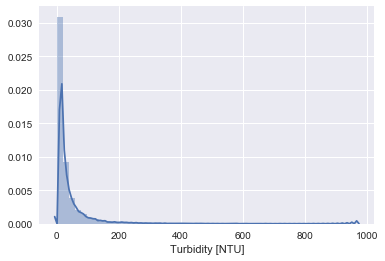

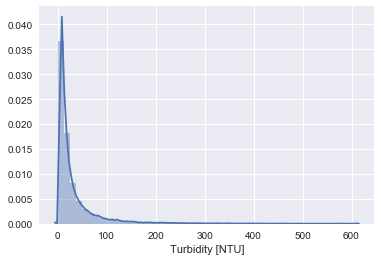

In [222]:
dfCharacteristics.loc[dfCharacteristics['Turbidity [NTU]'] < 0,['Turbidity [NTU]']] = np.nan # delete negatives
dfCharacteristics['Turbidity [NTU]'] = outlier_std(dfCharacteristics['Turbidity [NTU]'],stds=8,loops=1,plot=True)

# Wind direction

In [223]:
oldname = 'Wind direction (direction from, expressed 0-360 deg) [Deg]'
newname = 'Wind direction [deg]'
dfCharacteristics = dfCharacteristics.rename(columns = {oldname : newname})
dfCharacteristics[newname] = dfCharacteristics[newname]

### Remove outliers

In [224]:
outlier_std(dfCharacteristics['Wind direction [deg]'],stds=3,loops=1,plot=False);

Before Mean=187.314815 ----- After Mean=187.314815
0 points deleted out of 174763 total.----------------------


# Wind velocity
m/s chosen

In [225]:
display(dfCharacteristics.filter(regex = 'Wind velocity *').dropna()) # no overlapping values

,CharacteristicName,Wind velocity [m/sec],Wind velocity [mph]
MonitoringLocationIdentifier,dateTime,,


In [226]:
scales  = [1,0.44704]
columns = ['Wind velocity [m/sec]','Wind velocity [mph]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Wind velocity [mph] deleted...


### Remove outliers

In [227]:
outlier_std(dfCharacteristics['Wind velocity [m/sec]'],stds=3,loops=1,plot=False);

Before Mean=5.109117 ----- After Mean=5.109117
0 points deleted out of 174763 total.----------------------


# pH

In [228]:
display(dfCharacteristics.filter(regex = 'pH *').dropna()) # no overlapping values

,CharacteristicName,pH [None],pH [],pH [mg/l],pH [std units]
MonitoringLocationIdentifier,dateTime,,,,


In [229]:
scales  = [1,1,1,1]
columns = ['pH [None]', 'pH []', 'pH [mg/l]', 'pH [std units]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

pH [] deleted...
pH [mg/l] deleted...
pH [std units] deleted...


### Remove outliers

In [230]:
dfCharacteristics['pH [None]'] = outlier_std(dfCharacteristics['pH [None]'],stds=5,loops=2,plot=False)

Before Mean=7.899163 ----- After Mean=7.899815
1164 points deleted out of 174763 total.----------------------


# Export

In [231]:
dfCharacteristics.to_pickle('characteristics.p')
dfCharacteristics.to_csv('characteristics.csv')

In [232]:
list(dfCharacteristics)

['Barometric pressure [mm/Hg]',
 'Chlorine [mg/l]',
 'Conductivity [uS/cm]',
 'Depth [m]',
 'Escherichia coli [#/100ml]',
 'Floating garbage [list]',
 'Floating algae mat [list]',
 'Floating debris [list]',
 'Flow [m3/sec]',
 'Nitrate [mg/l]',
 'Precipitation [in/week]',
 'Sulfate [mg/l]',
 'Temperature, air [deg C]',
 'Temperature, water [deg C]',
 'Total suspended solids [mg/l]',
 'Turbidity [NTU]',
 'Wind direction [deg]',
 'Wind velocity [m/sec]',
 'pH [None]']

In [233]:
dfs = DataFrameSummary(dfCharacteristics)

NameError: name 'DataFrameSummary' is not defined

In [ ]:
dfs.summary()

In [ ]:
#for (i,j,k) in itertools.combinations(range(0,len(dfCharacteristics.columns)),3):
#    if len(dfCharacteristics.iloc[:,(i,j,k)].dropna()) > 1:
#        try:
#            sns.interactplot(dfCharacteristics.iloc[:,(i,j,k)].columns.values[0],
#                             dfCharacteristics.iloc[:,(i,j,k)].columns.values[1],
#                             dfCharacteristics.iloc[:,(i,j,k)].columns.values[2],
#                             dfCharacteristics)
#        except:
#            continue

In [ ]:
#from bokeh.plotting import figure, show
#from bokeh.io import output_notebook
#p = figure()
#p.circle(dfCharacteristics['dateTime'], dfCharacteristics['Sulfate [mg/l]'])
#output_notebook()
#show(p)

In [ ]:
display(dfCharacteristics.iloc[0,:])

In [ ]:
dfCharacteristics.var(level=0)

In [ ]:
dfCharacteristics.corr()